In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define transformations for the dataset
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize((0.5,), (0.5,)),  # Normalize images
    ]
)

# Download and load the training and test datasets
train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

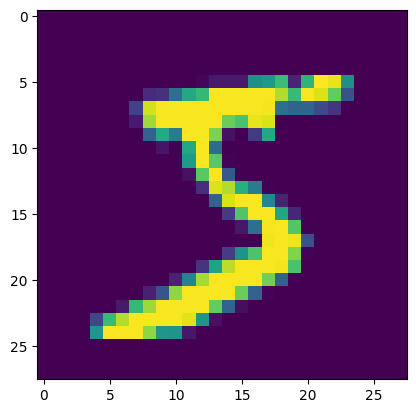

In [2]:
def imshow(img):
    npimg = img[0].numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


imshow(train_dataset[0])

In [3]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

In [4]:
model = NeuralNet()


def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if (i + 1) % 100 == 0:
                print(
                    f"Epoch {epoch + 1}/{num_epochs}, Step {i + 1}, Loss: {loss.item()}"
                )

In [5]:
train_model(
    model, train_loader, nn.CrossEntropyLoss(), optim.Adam(model.parameters(), lr=0.001)
)

Epoch 1/5, Step 100, Loss: 0.74443119764328
Epoch 1/5, Step 200, Loss: 0.5120555758476257
Epoch 1/5, Step 300, Loss: 0.488384872674942
Epoch 1/5, Step 400, Loss: 0.41190996766090393
Epoch 1/5, Step 500, Loss: 0.5318652391433716
Epoch 1/5, Step 600, Loss: 0.3392443358898163
Epoch 1/5, Step 700, Loss: 0.3941456079483032
Epoch 1/5, Step 800, Loss: 0.2174713909626007
Epoch 1/5, Step 900, Loss: 0.22120991349220276
Epoch 2/5, Step 100, Loss: 0.24053364992141724
Epoch 2/5, Step 200, Loss: 0.25982069969177246
Epoch 2/5, Step 300, Loss: 0.1457451432943344
Epoch 2/5, Step 400, Loss: 0.17976893484592438
Epoch 2/5, Step 500, Loss: 0.2656867802143097
Epoch 2/5, Step 600, Loss: 0.2540113627910614
Epoch 2/5, Step 700, Loss: 0.1499020755290985
Epoch 2/5, Step 800, Loss: 0.15715086460113525
Epoch 2/5, Step 900, Loss: 0.21626344323158264
Epoch 3/5, Step 100, Loss: 0.2217206060886383
Epoch 3/5, Step 200, Loss: 0.05805328115820885
Epoch 3/5, Step 300, Loss: 0.10314220935106277
Epoch 3/5, Step 400, Loss: 0

In [6]:
model.eval()  # trun train mode OFF

NeuralNet(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

In [7]:
total = 0
correct = 0

with torch.no_grad():  # No need to compute gradients
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 96.46%


In [8]:
def display_model_predictions(model, test_loader, num_images=5):
    images, labels = next(iter(test_loader))
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        image = images[i] / 2 + 0.5  # Unnormalize
        axes[i].imshow(image.permute(1, 2, 0).numpy())
        axes[i].set_title(f"Label: {labels[i]}, Predicted: {predicted[i]}")
        axes[i].axis("off")
    plt.show()

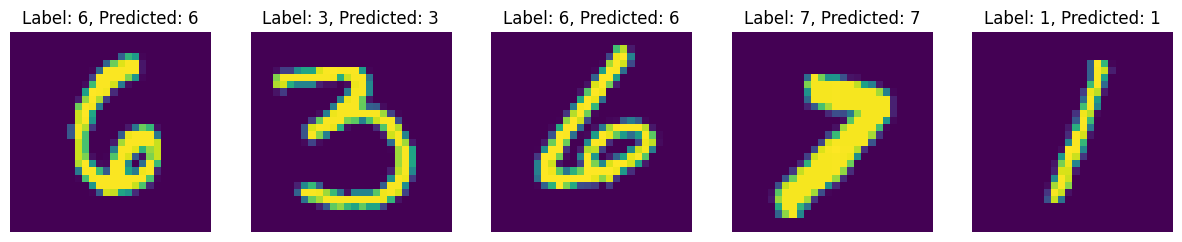

In [9]:
display_model_predictions(model, test_loader)

In [10]:
from torchsummary import summary


summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


### Compare with random forest

In [11]:
from sklearn.ensemble import RandomForestClassifier


run_rf = False  # Set to True to run the random forest model

if run_rf:
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(train_dataset.data.view(-1, 28 * 28), train_dataset.targets)

    print(
        f"Accuracy: {rf.score(test_dataset.data.view(-1, 28 * 28), test_dataset.targets) * 100:.2f}%"
    )

### Both OK
